**Loading and Pre-Processing Bulgarian and USA (benchmark) Death and Exposure Rates**

In [1]:
import pandas as pd
import re
from io import StringIO
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def read_tabular_file(filepath):
    """
    Reads a text file with metadata lines and a whitespace-delimited table.
    Returns a DataFrame with columns: Year, Age, Female, Male, Total.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_idx = next(i for i, line in enumerate(lines) if line.strip().startswith('Year'))

    table_str = ''.join(lines[header_idx:]).strip()

    df = pd.read_csv(
        StringIO(table_str),
        sep=r'\s+',
        engine='python'
    )
    return df

bulgaria_exposures_df = read_tabular_file('/content/Bulgaria_Exposures_1x1.txt')
bulgaria_deaths_df = read_tabular_file('/content/Bulgaria_Deaths_1x1.txt')

usa_exposure_df = read_tabular_file('/content/USA_Exposures_1x1.txt')
usa_deaths_df = read_tabular_file('/content/USA_Deaths_1x1.txt')


In [2]:
usa_deaths_df

,Year,Age,Female,Male,Total
0,1933,0,52615.77,68438.11,121053.88
1,1933,1,8917.13,10329.16,19246.29
2,1933,2,4336.92,5140.05,9476.97
3,1933,3,3161.59,3759.88,6921.47
4,1933,4,2493.84,2932.59,5426.43
...,...,...,...,...,...
10096,2023,106,569.01,89.00,658.01
10097,2023,107,282.01,39.01,321.02
10098,2023,108,153.00,17.00,170.00
10099,2023,109,90.00,11.00,101.00


In [3]:
bulgaria_deaths_df

,Year,Age,Female,Male,Total
0,1947,0,10197.46,12378.73,22576.19
1,1947,1,2152.10,2298.13,4450.23
2,1947,2,871.04,856.05,1727.09
3,1947,3,423.02,386.02,809.04
4,1947,4,306.02,300.02,606.04
...,...,...,...,...,...
8320,2021,106,1.91,0.39,2.30
8321,2021,107,0.68,0.00,0.68
8322,2021,108,0.00,0.00,0.00
8323,2021,109,0.00,0.00,0.00


LSTM Based Time Varying LC Model

In [4]:
def preprocess_df(exposures_df, deaths_df):
    for df in (exposures_df, deaths_df):
        df['Age'] = df['Age'].astype(str).replace({'110+': '110'}).astype(int)
    exp = exposures_df.pivot(index='Year', columns='Age', values='Total')
    dth = deaths_df   .pivot(index='Year', columns='Age', values='Total')
    if 110 in exp.columns:
        exp = exp.drop(columns=110)
        dth = dth.drop(columns=110)
    ages = exp.columns.intersection(dth.columns).sort_values()
    exp, dth = exp[ages], dth[ages]
    return dth / exp

def life_table(mx):
    ε = 1e-8
    mx = np.maximum(mx, ε)
    q = mx / (1 + 0.5*mx); q[-1] = 1.0
    p = 1 - q
    n = len(mx)
    l = np.empty(n+1); l[0] = 1.0
    for i in range(n):
        l[i+1] = l[i]*p[i]
    L = np.empty(n)
    for i in range(n-1):
        L[i] = 0.5*(l[i] + l[i+1])
    L[-1] = l[-1]/mx[-1]
    T = np.empty(n)
    T[-1] = L[-1]
    for i in range(n-2, -1, -1):
        T[i] = L[i] + T[i+1]
    e0 = T[0]
    d = l[:-1] - l[1:]
    e_x = T / l[:-1]
    disp = np.sum(d * e_x)
    return e0, disp

def compute_gap_series(m_bench, m_tgt):
    yrs = sorted(m_bench.index.intersection(m_tgt.index))
    gaps = []
    for y in yrs:
        e0_b, _ = life_table(m_bench.loc[y].values)
        e0_t, _ = life_table(m_tgt.loc[y].values)
        gaps.append(e0_b - e0_t)
    return np.array(yrs), np.array(gaps)

def compute_weights(g):
    gT = g[-1]
    ratio = np.clip((gT - g) / gT, 1e-6, 1.0)
    inv   = 1.0 / ratio
    return 0.5 * (1 + np.sin((np.pi/2) * inv))


class GapDataset(Dataset):
    def __init__(self, g, seq_len):
        self.X, self.y = [], []
        g_t = torch.tensor(g, dtype=torch.float32).unsqueeze(-1)
        ω   = torch.tensor(compute_weights(g), dtype=torch.float32)
        for i in range(seq_len, len(g)):
            self.X.append(g_t[i-seq_len:i])
            self.y.append(ω[i])
        self.X = torch.stack(self.X)
        self.y = torch.stack(self.y)

    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]


class WeightNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        h_last = out[:, -1, :]
        logit  = self.fc(h_last)
        ω      = torch.sigmoid(logit)
        return ω.squeeze(-1)

In [5]:
m_usa = preprocess_df(usa_exposure_df,     usa_deaths_df)
m_bul = preprocess_df(bulgaria_exposures_df, bulgaria_deaths_df)

years, gap_series = compute_gap_series(m_usa, m_bul)
gap_pd = pd.Series(gap_series, index=years)
gap_pd = gap_pd.interpolate().ffill().bfill()
years      = gap_pd.index.values
gap_series = gap_pd.values

gap_mean, gap_std = gap_series.mean(), gap_series.std()
gaps_norm = (gap_series - gap_mean) / gap_std

seq_len, batch_size = 10, 16
ds = GapDataset(gaps_norm, seq_len)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

model   = WeightNet(input_size=1, hidden_size=32, num_layers=2)
opt     = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


metrics = []
epochs = 50
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    for X, y in dl:
        opt.zero_grad()
        y_pred = model(X)
        loss   = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        epoch_loss += loss.item() * X.size(0)
    mse  = epoch_loss / len(ds)
    rmse = np.sqrt(mse)
    metrics.append({'epoch': epoch, 'mse': mse, 'rmse': rmse})
    print(f"Epoch {epoch:2d} — MSE: {mse:.6f}, RMSE: {rmse:.6f}")


metrics_df_lc = pd.DataFrame(metrics)
print("\nTraining metrics:\n", metrics_df_lc)

Epoch  1 — MSE: 0.147708, RMSE: 0.384327
Epoch  2 — MSE: 0.140483, RMSE: 0.374811
Epoch  3 — MSE: 0.134225, RMSE: 0.366367
Epoch  4 — MSE: 0.126104, RMSE: 0.355111
Epoch  5 — MSE: 0.117163, RMSE: 0.342291
Epoch  6 — MSE: 0.106949, RMSE: 0.327030
Epoch  7 — MSE: 0.098157, RMSE: 0.313300
Epoch  8 — MSE: 0.090124, RMSE: 0.300206
Epoch  9 — MSE: 0.089125, RMSE: 0.298538
Epoch 10 — MSE: 0.089159, RMSE: 0.298595
Epoch 11 — MSE: 0.083207, RMSE: 0.288456
Epoch 12 — MSE: 0.080486, RMSE: 0.283700
Epoch 13 — MSE: 0.077510, RMSE: 0.278406
Epoch 14 — MSE: 0.074376, RMSE: 0.272719
Epoch 15 — MSE: 0.071571, RMSE: 0.267527
Epoch 16 — MSE: 0.070006, RMSE: 0.264586
Epoch 17 — MSE: 0.067381, RMSE: 0.259579
Epoch 18 — MSE: 0.065132, RMSE: 0.255210
Epoch 19 — MSE: 0.063220, RMSE: 0.251436
Epoch 20 — MSE: 0.061914, RMSE: 0.248824
Epoch 21 — MSE: 0.060669, RMSE: 0.246310
Epoch 22 — MSE: 0.058836, RMSE: 0.242562
Epoch 23 — MSE: 0.056908, RMSE: 0.238553
Epoch 24 — MSE: 0.056270, RMSE: 0.237213
Epoch 25 — MSE: 

Comparison with Baseline models (Baseline 1: Basic LSTM (1-layer) and GLM)

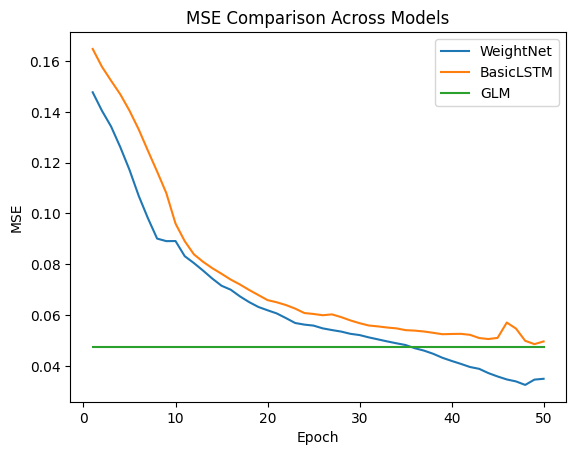

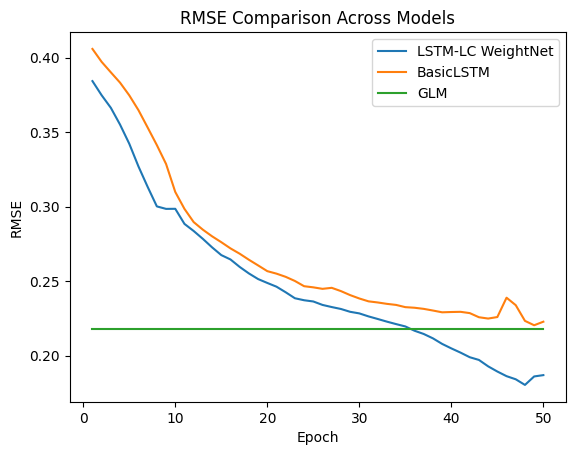

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


baseline1 = WeightNet(input_size=1, hidden_size=32, num_layers=1)
opt1     = optim.Adam(baseline1.parameters(), lr=1e-3)
metrics_baseline1 = []

for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    for X, y in dl:
        opt1.zero_grad()
        y_pred = baseline1(X)
        loss   = loss_fn(y_pred, y)
        loss.backward()
        opt1.step()
        epoch_loss += loss.item() * X.size(0)
    mse  = epoch_loss / len(ds)
    rmse = np.sqrt(mse)
    metrics_baseline1.append({'epoch': epoch, 'mse': mse, 'rmse': rmse})

metrics_df_baseline1 = pd.DataFrame(metrics_baseline1)

X_np = ds.X.squeeze(-1).numpy()  # shape (N, seq_len)
y_np = ds.y.numpy()

glm = LinearRegression().fit(X_np, y_np)
y_pred_glm = glm.predict(X_np)

mse_glm  = mean_squared_error(y_np, y_pred_glm)
rmse_glm = np.sqrt(mse_glm)


glm_mse_list  = [mse_glm]  * epochs
glm_rmse_list = [rmse_glm] * epochs

metrics_df_glm = pd.DataFrame({
    'epoch': list(range(1, epochs+1)),
    'mse':   glm_mse_list,
    'rmse':  glm_rmse_list
})

plt.figure()
plt.plot(metrics_df_lc['epoch'], metrics_df_lc['mse'], label='WeightNet')
plt.plot(metrics_df_baseline1['epoch'], metrics_df_baseline1['mse'], label='BasicLSTM')
plt.plot(metrics_df_glm['epoch'], metrics_df_glm['mse'], label='GLM')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE Comparison Across Models')
plt.show()

plt.figure()
plt.plot(metrics_df_lc['epoch'], metrics_df_lc['rmse'], label='LSTM-LC WeightNet')
plt.plot(metrics_df_baseline1['epoch'], metrics_df_baseline1['rmse'], label='BasicLSTM')
plt.plot(metrics_df_glm['epoch'], metrics_df_glm['rmse'], label='GLM')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE Comparison Across Models')
plt.show()




In [7]:
comparison_df = pd.DataFrame({
    'epoch': metrics_df_lc['epoch'],
    'weightnet_mse': metrics_df_lc['mse'],
    'basic_lstm_mse': metrics_df_baseline1['mse'],
    'glm_mse': glm_mse_list,
    'weightnet_rmse': metrics_df_lc['rmse'],
    'basic_lstm_rmse': metrics_df_baseline1['rmse'],
    'glm_rmse': glm_rmse_list,
})
comparison_df

,epoch,weightnet_mse,basic_lstm_mse,glm_mse,weightnet_rmse,basic_lstm_rmse,glm_rmse
0,1,0.147708,0.164771,0.047581,0.384327,0.405920,0.21813
1,2,0.140483,0.157786,0.047581,0.374811,0.397223,0.21813
2,3,0.134225,0.152252,0.047581,0.366367,0.390194,0.21813
3,4,0.126104,0.146896,0.047581,0.355111,0.383270,0.21813
4,5,0.117163,0.140459,0.047581,0.342291,0.374779,0.21813
5,6,0.106949,0.133091,0.047581,0.327030,0.364817,0.21813
6,7,0.098157,0.124713,0.047581,0.313300,0.353147,0.21813
7,8,0.090124,0.116512,0.047581,0.300206,0.341338,0.21813
8,9,0.089125,0.108031,0.047581,0.298538,0.328681,0.21813
9,10,0.089159,0.096037,0.047581,0.298595,0.309898,0.21813


In [8]:
final = comparison_df[comparison_df.epoch == epochs].iloc[0]

for model in ['basic_lstm', 'glm']:
    # percent improvement in MSE
    pct_mse  = (final[f'{model}_mse']  - final['weightnet_mse'])  / final[f'{model}_mse']  * 100
    # percent improvement in RMSE
    pct_rmse = (final[f'{model}_rmse'] - final['weightnet_rmse']) / final[f'{model}_rmse'] * 100
    print(f"LC vs {model.upper():8s}: MSE ↓ {pct_mse:.2f}%, RMSE ↓ {pct_rmse:.2f}%")


LC vs BASIC_LSTM: MSE ↓ 29.60%, RMSE ↓ 16.09%
LC vs GLM     : MSE ↓ 26.55%, RMSE ↓ 14.30%
